## Largely adapted from files in the original_source folder

In [1]:

import os
import time

import skimage 
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import PIL

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset as torchDataset
import torchvision as tv
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle

import shutil

import pydicom

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.catch_warnings()

gpu_available = True
debug = False

original_image_shape = 1024

datapath_orig = os.environ.get("TRAINML_DATA_PATH")
image_path = datapath_orig+"/stage_2_train_images"
datapath_prep = os.environ.get("TRAINML_MODEL_PATH")
datapath_out = os.environ.get("TRAINML_MODEL_PATH")

In [2]:
# from data_processing import build_training_csv
# build_training_csv(image_path, datapath_orig, datapath_prep)

In [3]:
df_train = pd.read_csv(datapath_prep+'/train.csv')
df_train.head(3)

,patientId,PatientSex,PatientAge,ViewPosition,x,y,width,height,Target,class
0,610bb23b-30af-4868-8d53-f90cda513fc6,M,57.0,AP,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,4c445a68-b7af-455c-b8f0-a94a4cc6eb13,M,35.0,PA,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,e88711cb-e03b-4570-a531-8ac8a7f9c6f5,F,22.0,PA,NaN,NaN,NaN,NaN,0,Normal


count      9555.000000
mean      77523.448038
std       51807.689206
min        2320.000000
25%       37535.500000
50%       64829.000000
75%      106491.500000
max      371184.000000
Name: box_area, dtype: float64

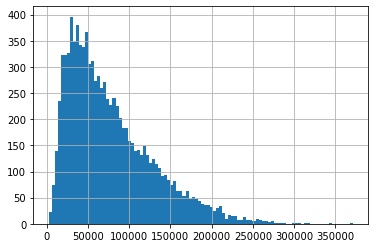

In [4]:
df_train['box_area'] = df_train['width'] * df_train['height']
df_train['box_area'].hist(bins=100)
df_train['box_area'].describe()

In [5]:
min_box_area = 10000
validation_frac = 0.10

df_train = df_train.sample(frac=1, random_state=42) # .sample(frac=1) does the shuffling
pIds = [pId for pId in df_train['patientId'].unique()]

pIds_valid = pIds[ : int(round(validation_frac*len(pIds)))]
pIds_train = pIds[int(round(validation_frac*len(pIds))) : ]

print('{} patient IDs shuffled and {}% of them used in validation set.'.format(len(pIds), validation_frac*100))
print('{} images went into train set and {} images went into validation set.'.format(len(pIds_train), len(pIds_valid)))


26684 patient IDs shuffled and 10.0% of them used in validation set.
24016 images went into train set and 2668 images went into validation set.


In [6]:
from dataset import get_boxes_per_patient
pId_boxes_dict = {}
for pId in df_train.loc[(df_train['Target']==1)]['patientId'].unique().tolist():
    pId_boxes_dict[pId] = get_boxes_per_patient(df_train, pId)
print('{} ({:.1f}%) images have target boxes.'.format(len(pId_boxes_dict), 100*(len(pId_boxes_dict)/len(pIds))))


6012 (22.5%) images have target boxes.


In [7]:

# define a MinMaxScaler function for the images
def imgMinMaxScaler(img, scale_range):
    """
    :param img: image to be rescaled
    :param scale_range: (tuple) (min, max) of the desired rescaling
    """
    warnings.filterwarnings("ignore")
    img = img.astype('float64')
    img_std = (img - np.min(img)) / (np.max(img) - np.min(img))
    img_scaled = img_std * float(scale_range[1] - scale_range[0]) + float(scale_range[0])
    # round at closest integer and transform to integer 
    img_scaled = np.rint(img_scaled).astype('uint8')

    return img_scaled



# define a "warping" image/mask function 
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       Code adapted from https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
    """
    assert len(image.shape)==2, 'Image must have 2 dimensions.'

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    image_warped = map_coordinates(image, indices, order=1).reshape(shape)
    
    return image_warped



# define the data generator class
class PneumoniaDataset(torchDataset):
    """
        Pneumonia dataset that contains radiograph lung images as .dcm. 
        Each patient has one image named patientId.dcm.
    """

    def __init__(self, root, pIds, predict, boxes, rescale_factor=1, transform=None, rotation_angle=0, warping=False):
        """
        :param root: it has to be a path to the folder that contains the dataset folders
        :param subset: 'train' or 'test'
        :param pIds: list of patient IDs
        :param predict: boolean, if true returns images and target labels, otherwise returns only images
        :param boxes: a {patientId : list of boxes} dictionary (ex: {'pId': [[x1, y1, w1, h1], [x2, y2, w2, h2]]}
        :param rescale_factor: image rescale factor in network (image shape is supposed to be square)
        :param transform: transformation applied to the images and their target masks
        :param rotation_angle: float, defines range of random rotation angles for augmentation (-rotation_angle, +rotation_angle)
        :param warping: boolean, whether applying augmentation warping to image
        """
        
        # initialize variables
        self.root = os.path.expanduser(root)
        self.pIds = pIds
        self.predict = predict
        self.boxes = boxes
        self.rescale_factor = rescale_factor
        self.transform = transform
        self.rotation_angle = rotation_angle
        self.warping = warping

        self.data_path = f"{self.root}/"
        
    def __getitem__(self, index):
        # get the corresponding pId
        pId = self.pIds[index]
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.data_path, pId+'.dcm')).pixel_array
        # check if image is square
        if (img.shape[0]!=img.shape[1]):
            raise RuntimeError('Image shape {} should be square.'.format(img.shape))
        original_image_shape = img.shape[0]
        # calculate network image shape
        image_shape = original_image_shape / self.rescale_factor
        # check if image_shape is an integer
        if (image_shape != int(image_shape)):
            raise RuntimeError('Network image shape should be an integer.'.format(image_shape))
        image_shape = int(image_shape)
        # resize image 
        # IMPORTANT: skimage resize function rescales the output from 0 to 1, and pytorch doesn't like this!
        # One solution would be using torchvision rescale function (but need to differentiate img and target transforms)
        # Here I use skimage resize and then rescale the output again from 0 to 255
        img = resize(img, (image_shape, image_shape), mode='reflect')
        # recale image from 0 to 255
        img = imgMinMaxScaler(img, (0,255))
        # image warping augmentation
        if self.warping:
            img = elastic_transform(img, image_shape*2., image_shape*0.1)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        # apply rotation augmentation
        if self.rotation_angle>0:
            angle = self.rotation_angle * (2 * np.random.random_sample() - 1) # generate random angle 
            img = tv.transforms.functional.to_pil_image(img)
            img = tv.transforms.functional.rotate(img, angle, resample=PIL.Image.BILINEAR)
                                            
        # apply transforms to image
        if self.transform is not None:
            img = self.transform(img)
        
        if not self.predict:
            # create target mask
            target = np.zeros((image_shape, image_shape))
            # if patient ID has associated target boxes (=if image contains pneumonia)
            if pId in self.boxes:
                # loop through boxes
                for box in self.boxes[pId]:
                    # extract box coordinates 
                    x, y, w, h = box
                    # rescale box coordinates
                    x = int(round(x/rescale_factor))
                    y = int(round(y/rescale_factor))
                    w = int(round(w/rescale_factor))
                    h = int(round(h/rescale_factor))
                    # create a mask of 1s (255 is used because pytorch will rescale to 0-1) inside the box
                    target[y:y+h, x:x+w] = 255 #
                    target[target>255] = 255 # correct in case of overlapping boxes (shouldn't happen)
            # add trailing channel dimension
            target = np.expand_dims(target, -1)   
            target = target.astype('uint8')
            # apply rotation augmentation
            if self.rotation_angle>0:
                target = tv.transforms.functional.to_pil_image(target)
                target = tv.transforms.functional.rotate(target, angle, resample=PIL.Image.BILINEAR)
            # apply transforms to target
            if self.transform is not None:
                target = self.transform(target)
            return img, target, pId
        else: 
            return img, pId

    def __len__(self):
        return len(self.pIds)



In [8]:

rescale_factor = 4 # resize factor to reduce image size (new_image_shape = original_image_shape / rescale_factor)
batch_size = 10

# recalculate minimum box area
min_box_area = int(round(min_box_area / float(rescale_factor**2)))

# TBD add normalization of images into transforms
# define transformation 
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

# create datasets
dataset_train = PneumoniaDataset(root=image_path, pIds=pIds_train, predict=False, 
                                 boxes=pId_boxes_dict, rescale_factor=rescale_factor, transform=transform,
                                 rotation_angle=3, warping=True)

dataset_valid = PneumoniaDataset(root=image_path, pIds=pIds_valid, predict=False, 
                                 boxes=pId_boxes_dict, rescale_factor=rescale_factor, transform=transform,
                                 rotation_angle=0, warping=False)

# define the dataloaders with the previous dataset
loader_train = DataLoader(dataset=dataset_train,
                           batch_size=batch_size,
                           shuffle=True) 

loader_valid = DataLoader(dataset=dataset_valid,
                           batch_size=batch_size,
                           shuffle=True) 



# Check if train images have been properly loaded
print('{} images in train set and {} images in validation set.'.format(len(dataset_train),
                                                                                               len(dataset_valid)))

24016 images in train set and 2668 images in validation set.


In [9]:
img_batch, target_batch, pId_batch = next(iter(loader_train))
print('Tensor batch size:', img_batch.size())


Tensor batch size: torch.Size([10, 1, 256, 256])



Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: e9b04c75-09ef-44f2-9bda-ed072c38ecf4
Image scale: 0.0 - 1.0
Target mask scale: 0.0 - 0.0


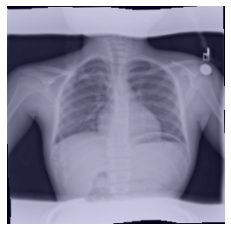


Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: 4769fa12-e694-48ce-ad4e-0628e5dd75f0
Image scale: 0.0 - 0.9921568632125854
Target mask scale: 0.0 - 0.0


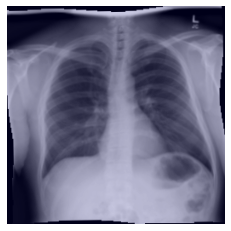


Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: d903621a-9a92-470b-bc66-e0287c6490ad
Image scale: 0.0 - 0.9921568632125854
Target mask scale: 0.0 - 0.0


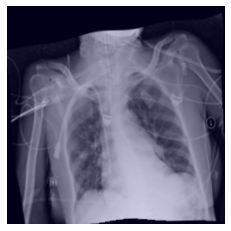


Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: 51fbcba7-7bdb-49de-818c-066ec4ff155f
Image scale: 0.0 - 0.9921568632125854
Target mask scale: 0.0 - 1.0


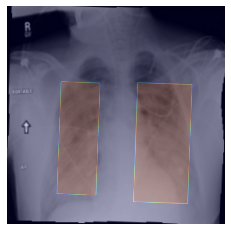


Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: ee79c117-3579-49d7-a7cd-acd1a580cb4e
Image scale: 0.0 - 0.9921568632125854
Target mask scale: 0.0 - 0.0


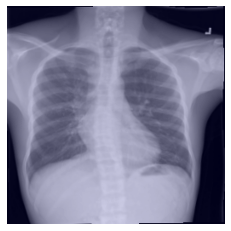

In [10]:

# Display some examples
for i in np.random.choice(len(dataset_train), size=5, replace=False):
    img, target, pId = dataset_train[i] # picking an image with pneumonia
    print('\nImage and mask shapes:', img.shape, target.shape)
    print('Patient ID:', pId)
    print('Image scale: {} - {}'.format(img[0].min(), img[0].max()))
    print('Target mask scale: {} - {}'.format(target[0].min(), target[0].max()))
    plt.imshow(img[0], cmap=mpl.cm.gist_gray) # [0] is the channel index (here there's just one channel)
    plt.imshow(target[0], cmap=mpl.cm.jet, alpha=0.2)
    plt.axis('off')
    plt.show()



In [11]:

# Define the nn convolutional block
class conv_block(nn.Module):
    """
    Define the [convolution - batch normalization - activation] block 
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True,
                 bn_momentum=0.9, alpha_leaky=0.03):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=bn_momentum)
        self.activ = nn.LeakyReLU(negative_slope=alpha_leaky)

    def forward(self, x):
        return self.activ(self.bn(self.conv(x)))
    
# Define the nn transposed convolutional block
class conv_t_block(nn.Module):
    """
    Define the [convolution_transpose - batch normalization - activation] block 
    """

    def __init__(self, in_channels, out_channels, output_size=None, kernel_size=3, bias=True,
                 bn_momentum=0.9, alpha_leaky=0.03):
        super(conv_t_block, self).__init__()
        self.conv_t = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, 
                                         bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=bn_momentum)
        self.activ = nn.LeakyReLU(negative_slope=alpha_leaky)

    def forward(self, x, output_size):
        return self.activ(self.bn(self.conv_t(x, output_size=output_size)))    



# the actual model function is defined here
# NOTE: the comments are meant to help understand/check the input-output sizes of the tensor
#       and they assume an input image size of 256x256, 
#       but the model can accept larger/smaller sizes (tho I haven't debugged it yet)
class PneumoniaUNET(nn.Module):

    def __init__(self):
        super(PneumoniaUNET, self).__init__()
        
        self.down_1 = nn.Sequential(conv_block(in_channels=1, out_channels=64), conv_block(in_channels=64, out_channels=64))
        self.down_2 = nn.Sequential(conv_block(in_channels=64, out_channels=128), conv_block(in_channels=128, out_channels=128))
        self.down_3 = nn.Sequential(conv_block(in_channels=128, out_channels=256), conv_block(in_channels=256, out_channels=256))
        self.down_4 = nn.Sequential(conv_block(in_channels=256, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.down_5 = nn.Sequential(conv_block(in_channels=512, out_channels=512), conv_block(in_channels=512, out_channels=512))

        self.middle = nn.Sequential(conv_block(in_channels=512, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.middle_t = conv_t_block(in_channels=512, out_channels=256)

        self.up_5 = nn.Sequential(conv_block(in_channels=768, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.up_5_t = conv_t_block(in_channels=512, out_channels=256)
        self.up_4 = nn.Sequential(conv_block(in_channels=768, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.up_4_t = conv_t_block(in_channels=512, out_channels=128)
        self.up_3 = nn.Sequential(conv_block(in_channels=384, out_channels=256), conv_block(in_channels=256, out_channels=256))
        self.up_3_t = conv_t_block(in_channels=256, out_channels=64)
        self.up_2 = nn.Sequential(conv_block(in_channels=192, out_channels=128), conv_block(in_channels=128, out_channels=128))
        self.up_2_t = conv_t_block(in_channels=128, out_channels=32)
        self.up_1 = nn.Sequential(conv_block(in_channels=96, out_channels=64), conv_block(in_channels=64, out_channels=1))
        
    def forward(self, x):
        down1 = self.down_1(x) # (1x256x256 -> 64x256x256)
        out = F.max_pool2d(down1, kernel_size=2, stride=2) # (64x256x256 -> 64x128x128)

        down2 = self.down_2(out) # (64x128x128 -> 128x128x128)
        out = F.max_pool2d(down2, kernel_size=2, stride=2) # (128x128x128 -> 128x64x64)

        down3 = self.down_3(out) # (128x64x64 -> 256x64x64)
        out = F.max_pool2d(down3, kernel_size=2, stride=2) # (256x64x64 -> 256x32x32)

        down4 = self.down_4(out) # (256x32x32 -> 512x32x32)
        out = F.max_pool2d(down4, kernel_size=2, stride=2) # (512x32x32 -> 512x16x16)

        down5 = self.down_5(out) # (512x16x16 -> 512x16x16)
        out = F.max_pool2d(down5, kernel_size=2, stride=2) # (512x16x16 -> 512x8x8)

        out = self.middle(out) # (512x8x8 -> 512x8x8)
        out = self.middle_t(out, output_size=down5.size()) # (512x8x8 -> 256x16x16)

        out = torch.cat([down5, out], 1) # (512x16x16-concat-256x16x16 -> 768x16x16)
        out = self.up_5(out) # (768x16x16 -> 512x16x16)
        out = self.up_5_t(out, output_size=down4.size()) # (512x16x16 -> 256x32x32)

        out = torch.cat([down4, out], 1) # (512x32x32-concat-256x32x32 -> 768x32x32)
        out = self.up_4(out) # (768x32x32 -> 512x32x32)
        out = self.up_4_t(out, output_size=down3.size()) # (512x32x32 -> 128x64x64)
        
        out = torch.cat([down3, out], 1) # (256x64x64-concat-128x64x64 -> 384x64x64)
        out = self.up_3(out) # (384x64x64 -> 256x64x64)
        out = self.up_3_t(out, output_size=down2.size()) # (256x64x64 -> 64x128x128)
        
        out = torch.cat([down2, out], 1) # (128x128x128-concat-64x128x128 -> 192x128x128)
        out = self.up_2(out) # (192x128x128 -> 128x128x128)
        out = self.up_2_t(out, output_size=down1.size()) # (128x128x128 -> 32x256x256)
        
        out = torch.cat([down1, out], 1) # (64x256x256-concat-32x256x256 -> 96x256x256)
        out = self.up_1(out) # (96x256x256 -> 1x256x256)
        
        return out    



# # the actual model function is defined here
# # NOTE: the comments are meant to help understand/check the input-output sizes of the tensor
# #       and they assume an input image size of 256x256, 
# #       but the model can accept larger/smaller sizes (tho I haven't debugged it yet)
# class PneumoniaUNET(nn.Module):

#     def __init__(self):
#         super(PneumoniaUNET, self).__init__()
        
#         self.down_1 = conv_block(in_channels=1, out_channels=64)
#         self.down_2 = conv_block(in_channels=64, out_channels=128)
#         self.down_3 = conv_block(in_channels=128, out_channels=256)
#         self.down_4 = conv_block(in_channels=256, out_channels=512)
#         self.down_5 = conv_block(in_channels=512, out_channels=512)

#         self.middle = conv_block(in_channels=512, out_channels=512)
#         self.middle_t = conv_t_block(in_channels=512, out_channels=256)

#         self.up_5 = conv_block(in_channels=768, out_channels=512)
#         self.up_5_t = conv_t_block(in_channels=512, out_channels=256)
#         self.up_4 = conv_block(in_channels=768, out_channels=512)
#         self.up_4_t = conv_t_block(in_channels=512, out_channels=128)
#         self.up_3 = conv_block(in_channels=384, out_channels=256)
#         self.up_3_t = conv_t_block(in_channels=256, out_channels=64)
#         self.up_2 = conv_block(in_channels=192, out_channels=128)
#         self.up_2_t = conv_t_block(in_channels=128, out_channels=32)
#         self.up_1 = conv_block(in_channels=96, out_channels=1)
        
#     def forward(self, x):
#         down1 = self.down_1(x) # (1x256x256 -> 64x256x256)
#         out = F.max_pool2d(down1, kernel_size=2, stride=2) # (64x256x256 -> 64x128x128)

#         down2 = self.down_2(out) # (64x128x128 -> 128x128x128)
#         out = F.max_pool2d(down2, kernel_size=2, stride=2) # (128x128x128 -> 128x64x64)

#         down3 = self.down_3(out) # (128x64x64 -> 256x64x64)
#         out = F.max_pool2d(down3, kernel_size=2, stride=2) # (256x64x64 -> 256x32x32)

#         down4 = self.down_4(out) # (256x32x32 -> 512x32x32)
#         out = F.max_pool2d(down4, kernel_size=2, stride=2) # (512x32x32 -> 512x16x16)

#         down5 = self.down_5(out) # (512x16x16 -> 512x16x16)
#         out = F.max_pool2d(down5, kernel_size=2, stride=2) # (512x16x16 -> 512x8x8)

#         out = self.middle(out) # (512x8x8 -> 512x8x8)
#         out = self.middle_t(out, output_size=down5.size()) # (512x8x8 -> 256x16x16)

#         out = torch.cat([down5, out], 1) # (512x16x16-concat-256x16x16 -> 768x16x16)
#         out = self.up_5(out) # (768x16x16 -> 512x16x16)
#         out = self.up_5_t(out, output_size=down4.size()) # (512x16x16 -> 256x32x32)

#         out = torch.cat([down4, out], 1) # (512x32x32-concat-256x32x32 -> 768x32x32)
#         out = self.up_4(out) # (768x32x32 -> 512x32x32)
#         out = self.up_4_t(out, output_size=down3.size()) # (512x32x32 -> 128x64x64)
        
#         out = torch.cat([down3, out], 1) # (256x64x64-concat-128x64x64 -> 384x64x64)
#         out = self.up_3(out) # (384x64x64 -> 256x64x64)
#         out = self.up_3_t(out, output_size=down2.size()) # (256x64x64 -> 64x128x128)
        
#         out = torch.cat([down2, out], 1) # (128x128x128-concat-64x128x128 -> 192x128x128)
#         out = self.up_2(out) # (192x128x128 -> 128x128x128)
#         out = self.up_2_t(out, output_size=down1.size()) # (128x128x128 -> 32x256x256)
        
#         out = torch.cat([down1, out], 1) # (64x256x256-concat-32x256x256 -> 96x256x256)
#         out = self.up_1(out) # (96x256x256 -> 1x256x256)
        
#         return out    



# print model architecture
print(PneumoniaUNET())


PneumoniaUNET(
  (down_1): Sequential(
    (0): conv_block(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.03)
    )
    (1): conv_block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.03)
    )
  )
  (down_2): Sequential(
    (0): conv_block(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.03)
    )
    (1): conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
 

In [12]:


# Create the loss function
# Define the 2D Sigmoid + Binary Cross Entropy loss function BCEWithLogitsLoss
# TBD add weights for unbalanced class
# NOTE: Rather than using weights, I also intended to try implement focal loss (see RetinaNet)
class BCEWithLogitsLoss2d(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super(BCEWithLogitsLoss2d, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(weight, size_average)

    def forward(self, scores, targets):
        scores_flat = scores.view(-1)
        targets_flat = targets.view(-1)
        return self.loss(scores_flat, targets_flat)



# Define auxiliary metric functions

# define function that creates a square mask for a box from its coordinates 
def box_mask(box, shape=1024):
    """
    :param box: [x, y, w, h] box coordinates
    :param shape: shape of the image (default set to maximum possible value, set to smaller to save memory)
    :returns: (np.array of bool) mask as binary 2D array
    """
    x, y, w, h = box
    mask = np.zeros((shape, shape), dtype=bool)
    mask[y:y+h, x:x+w] = True 
    return mask

# # debug code for above function
# plt.imshow(box_mask([5,20,50,100], shape=256), cmap=mpl.cm.jet)

# define function that extracts confidence and coordinates of boxes from a prediction mask
def parse_boxes(msk, threshold=0.20, connectivity=None):
    """
    :param msk: (torch.Tensor) CxWxH tensor representing the prediction mask
    :param threshold: threshold in the range 0-1 above which a pixel is considered a positive target
    :param connectivity: connectivity parameter for skimage.measure.label segmentation (can be None, 1, or 2)
                         http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label
    :returns: (list, list) predicted_boxes, confidences
    """
    # extract 2d array
    msk = msk[0]
    # select pixels above threshold and mark them as positives (1) in an array of equal size as the input prediction mask
    pos = np.zeros(msk.shape)
    pos[msk>threshold] = 1.
    # label regions
    lbl = skimage.measure.label(pos, connectivity=connectivity)
    
    predicted_boxes = []
    confidences = []
    # iterate over regions and extract box coordinates
    for region in skimage.measure.regionprops(lbl):
        # retrieve x, y, height and width and add to prediction string
        y1, x1, y2, x2 = region.bbox
        h = y2 - y1
        w = x2 - x1
        c = np.nanmean(msk[y1:y2, x1:x2])
        # add control over box size (eliminate if too small)
        if w*h > min_box_area: 
            predicted_boxes.append([x1, y1, w, h])
            confidences.append(c)
    
    return predicted_boxes, confidences

# # debug code for above function
# plt.imshow(dataset_train[3][1][0], cmap=mpl.cm.jet) 
# print(dataset_train[3][1].shape)
# print(parse_boxes(dataset_train[3][1]))

# define function that creates prediction strings as expected in submission
def prediction_string(predicted_boxes, confidences):
    """
    :param predicted_boxes: [[x1, y1, w1, h1], [x2, y2, w2, h2], ...] list of predicted boxes coordinates 
    :param confidences: [c1, c2, ...] list of confidence values for the predicted boxes
    :returns: prediction string 'c1 x1 y1 w1 h1 c2 x2 y2 w2 h2 ...'
    """
    prediction_string = ''
    for c, box in zip(confidences, predicted_boxes):
        prediction_string += ' ' + str(c) + ' ' + ' '.join([str(b) for b in box])
    return prediction_string[1:]   

# # debug code for above function
# predicted_boxes, confidences = parse_boxes(dataset_train[3][1])
# print(predicted_boxes, confidences)
# print(prediction_string(predicted_boxes, confidences))

# define iou function
def IoU(pr, gt):
    """
    :param pr: (numpy_array(bool)) prediction array 
    :param gt: (numpy_array(bool)) ground truth array 
    :returns: IoU (pr, gt) = intersection (pr, gt) / union (pr, gt)
    """
    IoU = (pr & gt).sum() / ((pr | gt).sum() + 1.e-9)
    return IoU

# # debug code for above function
# pr = box_mask([50,60,100,150], shape=256)
# gt = box_mask([30,40,100,140], shape=256)
# plt.imshow(pr, cmap=mpl.cm.Reds, alpha=0.3)
# plt.imshow(gt, cmap=mpl.cm.Greens, alpha=0.3)
# print(IoU(pr, gt))

# define precision function
def precision(tp, fp, fn):
    """
    :param tp: (int) number of true positives
    :param fp: (int) number of false positives
    :param fn: (int) number of false negatives
    :returns: precision metric for one image at one threshold
    """
    return float(tp) / (tp + fp + fn + 1.e-9)

# # debug code for above function
# print(precision(3,1,1))

# define function that calculates the average precision of an image
def average_precision_image(predicted_boxes, confidences, target_boxes, shape=1024):
    """
    :param predicted_boxes: [[x1, y1, w1, h1], [x2, y2, w2, h2], ...] list of predicted boxes coordinates 
    :param confidences: [c1, c2, ...] list of confidence values for the predicted boxes
    :param target_boxes: [[x1, y1, w1, h1], [x2, y2, w2, h2], ...] list of target boxes coordinates 
    :param shape: shape of the boolean masks (default set to maximum possible value, set to smaller to save memory)
    :returns: average_precision
    """
    
    # if both predicted and target boxes are empty, precision is NaN (and doesn't count towards the batch average)
    if predicted_boxes == [] and target_boxes == []:
        return np.nan
    else:
        # if we have predicted boxes but no target boxes, precision is 0
        if len(predicted_boxes)>0 and target_boxes == []:
            return 0.0
        # if we have target boxes but no predicted boxes, precision is 0
        elif len(target_boxes)>0 and predicted_boxes == []:
            return 0.0
        # if we have both predicted and target boxes, proceed to calculate image average precision
        else:
            # define list of thresholds for IoU [0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75]
            thresholds = np.arange(0.4, 0.8, 0.05) 
            # sort boxes according to their confidence (from largest to smallest)
            predicted_boxes_sorted = list(reversed([b for _, b in sorted(zip(confidences, predicted_boxes), 
                                                                         key=lambda pair: pair[0])]))            
            average_precision = 0.0
            for t in thresholds: # iterate over thresholds
                # with a first loop we measure true and false positives
                tp = 0 # initiate number of true positives
                fp = len(predicted_boxes) # initiate number of false positives 
                for box_p in predicted_boxes_sorted: # iterate over predicted boxes coordinates
                    box_p_msk = box_mask(box_p, shape) # generate boolean mask
                    for box_t in target_boxes: # iterate over ground truth boxes coordinates
                        box_t_msk = box_mask(box_t, shape) # generate boolean mask
                        iou = IoU(box_p_msk, box_t_msk) # calculate IoU
                        if iou>t:
                            tp += 1 # if IoU is above the threshold, we got one more true positive
                            fp -= 1 # and one less false positive
                            break # proceed to the next predicted box
                # with a second loop we measure false negatives
                fn = len(target_boxes) # initiate number of false negatives
                for box_t in target_boxes: # iterate over ground truth boxes coordinates
                    box_t_msk = box_mask(box_t, shape) # generate boolean mask
                    for box_p in predicted_boxes_sorted: # iterate over predicted boxes coordinates
                        box_p_msk = box_mask(box_p, shape) # generate boolean mask
                        iou = IoU(box_p_msk, box_t_msk) # calculate IoU
                        if iou>t:
                            fn -= 1
                            break # proceed to the next ground truth box
                # TBD: this algo must be checked against the official Kaggle evaluation method which is still not clear...
                average_precision += precision(tp, fp, fn) / float(len(thresholds))
            return average_precision

# # debug code for above function
# confidences = [0.3, 0.9]
# predicted_boxes = [[20,20,60,70], [110,110,50,70]]
# target_boxes = [[25,25,60,70], [100,100,50,70]]#, [200, 200, 30, 50]]
# for box_p in predicted_boxes:
#     plt.imshow(box_mask(box_p, shape=256), cmap=mpl.cm.Reds, alpha=0.3)
# for box_t in target_boxes:
#     plt.imshow(box_mask(box_t, shape=256), cmap=mpl.cm.Greens, alpha=0.3)
# print(average_precision_image(predicted_boxes, confidences, target_boxes)) 

# define function that calculates the average precision of a batch of images
def average_precision_batch(output_batch, pIds, pId_boxes_dict, rescale_factor, shape=1024, return_array=False):
    """
    :param output_batch: cnn model output batch
    :param pIds: (list) list of patient IDs contained in the output batch
    :param rescale_factor: CNN image rescale factor
    :param shape: shape of the boolean masks (default set to maximum possible value, set to smaller to save memory)
    :returns: average_precision
    """
    
    batch_precisions = []
    for msk, pId in zip(output_batch, pIds): # iterate over batch prediction masks and relative patient IDs
        # retrieve target boxes from dictionary (quicker than from mask itself)
        target_boxes = pId_boxes_dict[pId] if pId in pId_boxes_dict else []
        # rescale coordinates of target boxes
        if len(target_boxes)>0:
            target_boxes = [[int(round(c/float(rescale_factor))) for c in box_t] for box_t in target_boxes]
        # extract prediction boxes and confidences
        predicted_boxes, confidences = parse_boxes(msk) 
        batch_precisions.append(average_precision_image(predicted_boxes, confidences, target_boxes, shape=shape))
    if return_array:
        return np.asarray(batch_precisions)
    else:
        return np.nanmean(np.asarray(batch_precisions)) 

# # debug code for above function
# targets = []
# pIds = []
# for i in range(5):
#     (img, target, pId) = dataset_train[i]
#     targets.append(target)
#     pIds.append(pId)
# # targets[0] = targets[1] #or pIds[0] = 'nan'
# average_precision_batch(targets, pIds, pId_boxes_dict, rescale_factor, shape=256)    



class RunningAverage():
    """A simple class that maintains the running average of a quantity
    
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """
    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
    
    def __call__(self):
        return self.total/float(self.steps)



def save_checkpoint(state, is_best, metric):
    """Saves model and training parameters at 'last.pth.tar'. If is_best==True, also saves
    'best.pth.tar'
    Args:
        state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
        is_best: (bool) True if it is the best model seen till now
    """
    filename = 'last.pth.tar'
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, metric+'.best.pth.tar')



In [13]:


# define the training function
def train(model, dataloader, optimizer, loss_fn, num_steps, pId_boxes_dict, rescale_factor, shape, save_summary_steps=5):
    # set model to train model
    model.train()

    summary = []
    loss_avg = RunningAverage()

    loss_avg_t_hist_ep, loss_t_hist_ep, prec_t_hist_ep = [], [], []

    # iterate over batches
    start = time.time()        
    
    for i, (input_batch, labels_batch, pIds_batch) in enumerate(dataloader):
        # break loop after num_steps batches (useful for debugging)
        if i > num_steps:
            break
        # Convert torch tensor to Variable
        input_batch = Variable(input_batch).cuda() if gpu_available else Variable(input_batch).float()
        labels_batch = Variable(labels_batch).cuda() if gpu_available else Variable(labels_batch).float()
            
        # compute output
        optimizer.zero_grad()
        output_batch = model(input_batch)

        # compute loss
        loss = loss_fn(output_batch, labels_batch)

        # compute gradient and do optimizer step
        loss.backward()
        optimizer.step()

        # update loss running average
        loss_avg.update(loss.item())
        loss_t_hist_ep.append(loss.item())
        loss_avg_t_hist_ep.append(loss_avg())

        # Evaluate summaries only once in a while
        if i % save_summary_steps == 0:
            # extract data from torch Variable, move to cpu
            output_batch = output_batch.data.cpu().numpy()
            # compute average precision on this batch
            prec_batch = average_precision_batch(output_batch, pIds_batch, pId_boxes_dict, rescale_factor, shape)
            prec_t_hist_ep.append(prec_batch)
            # log results
            summary_batch_string = "batch loss = {:05.7f} ;  ".format(loss.item())
            summary_batch_string += "average loss = {:05.7f} ;  ".format(loss_avg())
            summary_batch_string += "batch precision = {:05.7f} ;  ".format(prec_batch)
            print('--- Train batch {} / {}: '.format(i, num_steps) + summary_batch_string)
            delta_time = time.time() - start
            print('    {} batches processed in {:.2f} seconds'.format(save_summary_steps, delta_time))
            start = time.time()

    # log epoch summary
    metrics_string = "average loss = {:05.7f} ;  ".format(loss_avg())
    print("- Train epoch metrics summary: " + metrics_string)
    
    return loss_avg_t_hist_ep, loss_t_hist_ep, prec_t_hist_ep



def evaluate(model, dataloader, loss_fn, num_steps, pId_boxes_dict, rescale_factor, shape):

    # set model to evaluation mode
    model.eval()

    losses = []
    precisions = []

    # compute metrics over the dataset
    start = time.time()
    for i, (input_batch, labels_batch, pIds_batch) in enumerate(dataloader):
        # break loop after num_steps batches (useful for debugging)
        if i > num_steps:
            break
        # Convert torch tensor to Variable
        input_batch = Variable(input_batch).cuda() if gpu_available else Variable(input_batch).float()
        labels_batch = Variable(labels_batch).cuda() if gpu_available else Variable(labels_batch).float()

        # compute model output
        output_batch = model(input_batch)
        # compute loss of batch
        loss = loss_fn(output_batch, labels_batch)
        losses.append(loss.item())

        # extract data from torch Variable, move to cpu
        output_batch = output_batch.data.cpu()
        # compute individual precisions of batch images
        prec_batch = average_precision_batch(output_batch, pIds_batch, pId_boxes_dict, rescale_factor, shape, return_array=True)
        for p in prec_batch:
            precisions.append(p)
        print('--- Validation batch {} / {}: '.format(i, num_steps))

    # compute mean of all metrics in summary
    metrics_mean = {'loss' : np.nanmean(losses),
                    'precision' : np.nanmean(np.asarray(precisions))}
    metrics_string = "average loss = {:05.7f} ;  ".format(metrics_mean['loss'])
    metrics_string += "average precision = {:05.7f} ;  ".format(metrics_mean['precision'])
    print("- Eval metrics : " + metrics_string)
    delta_time = time.time() - start
    print('  Evaluation run in {:.2f} seconds.'.format(delta_time))
    
    return metrics_mean



def train_and_evaluate(model, train_dataloader, val_dataloader, lr_init, loss_fn, num_epochs, 
                       num_steps_train, num_steps_eval, pId_boxes_dict, rescale_factor, shape, restore_file=None):

    # reload weights from restore_file if specified
    if restore_file is not None:
        checkpoint = torch.load(restore_file)
        model.load_state_dict(checkpoint['state_dict'])
            
    best_val_loss = 1e+15
    best_val_prec = 0.0
    best_loss_model = None
    best_prec_model = None

    loss_t_history = []
    loss_v_history = []
    loss_avg_t_history = []
    prec_t_history = []
    prec_v_history = []

    for epoch in range(num_epochs):
        start = time.time()
        
        # define the optimizer
        lr = lr_init * 0.5**float(epoch) # reduce the learning rate at each epoch
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # Run one epoch
        print("Epoch {}/{}. Learning rate = {:05.3f}.".format(epoch + 1, num_epochs, lr))

        # train model for a whole epoc (one full pass over the training set)
        loss_avg_t_hist_ep, loss_t_hist_ep, prec_t_hist_ep = train(model, train_dataloader, optimizer, loss_fn, 
                                                                   num_steps_train, pId_boxes_dict, rescale_factor, shape)
        loss_avg_t_history += loss_avg_t_hist_ep
        loss_t_history += loss_t_hist_ep
        prec_t_history += prec_t_hist_ep
        
        # Evaluate for one epoch on validation set
        val_metrics = evaluate(model, val_dataloader, loss_fn, num_steps_eval, pId_boxes_dict, rescale_factor, shape)

        val_loss = val_metrics['loss']
        val_prec = val_metrics['precision']
        
        loss_v_history += len(loss_t_hist_ep) * [val_loss]
        prec_v_history += len(prec_t_hist_ep) * [val_prec]

        is_best_loss = val_loss<=best_val_loss
        is_best_prec = val_prec>=best_val_prec
        
        if is_best_loss:
            print("- Found new best loss: {:.4f}".format(val_loss))
            best_val_loss = val_loss
            best_loss_model = model
        if is_best_prec:
            print("- Found new best precision: {:.4f}".format(val_prec))
            best_val_prec = val_prec
            best_prec_model = model
            
        # Save best weights based on best_val_loss and best_val_prec
        save_checkpoint({'epoch': epoch + 1,
                         'state_dict': model.state_dict(),
                         'optim_dict' : optimizer.state_dict()},
                         is_best=is_best_loss,
                         metric='loss')
        save_checkpoint({'epoch': epoch + 1,
                         'state_dict': model.state_dict(),
                         'optim_dict' : optimizer.state_dict()},
                         is_best=is_best_prec,
                         metric='prec')
        
        delta_time = time.time() - start
        print('Epoch run in {:.2f} minutes'.format(delta_time/60.))

    histories = {'loss avg train' : loss_avg_t_history,
                 'loss train' : loss_t_history,
                 'precision train' : prec_t_history,
                 'loss validation' : loss_v_history, 
                 'precision validation' : prec_v_history}
    best_models = {'best loss model' : best_loss_model,
                   'best precision model' : best_prec_model}
    
    return histories, best_models




In [14]:

# train and evaluate the model

# define an instance of the model
model = PneumoniaUNET().cuda() if gpu_available else PneumoniaUNET()
# define the loss function
loss_fn = BCEWithLogitsLoss2d().cuda() if gpu_available else BCEWithLogitsLoss2d()
# define initial learning rate (will be reduced over epochs)
lr_init = 0.5

num_epochs = 2 if debug else 2
num_steps_train = 50 if debug else len(loader_train)
num_steps_eval = 10 if debug else len(loader_valid)

shape = int(round(original_image_shape / rescale_factor))


In [15]:

# Train the model
print("Starting training for {} epochs".format(num_epochs))
histories, best_models = train_and_evaluate(model, loader_train, loader_valid, lr_init, loss_fn, 
                                            num_epochs, num_steps_train, num_steps_eval, pId_boxes_dict, rescale_factor, shape)




Starting training for 2 epochs
Epoch 1/2. Learning rate = 0.500.
--- Train batch 0 / 2402: batch loss = 0.8831040 ;  average loss = 0.8831040 ;  batch precision = 0.0000000 ;  
    5 batches processed in 3.31 seconds
--- Train batch 5 / 2402: batch loss = 0.6723738 ;  average loss = 0.7128701 ;  batch precision = 0.0000000 ;  
    5 batches processed in 7.62 seconds
--- Train batch 10 / 2402: batch loss = 0.6576872 ;  average loss = 0.6903694 ;  batch precision = 0.0000000 ;  
    5 batches processed in 7.27 seconds
--- Train batch 15 / 2402: batch loss = 0.6465095 ;  average loss = 0.6786711 ;  batch precision = 0.0000000 ;  
    5 batches processed in 7.13 seconds
--- Train batch 20 / 2402: batch loss = 0.6404458 ;  average loss = 0.6700569 ;  batch precision = 0.0000000 ;  
    5 batches processed in 7.44 seconds
--- Train batch 25 / 2402: batch loss = 0.6329016 ;  average loss = 0.6629072 ;  batch precision = 0.0000000 ;  
    5 batches processed in 7.05 seconds
--- Train batch 30 

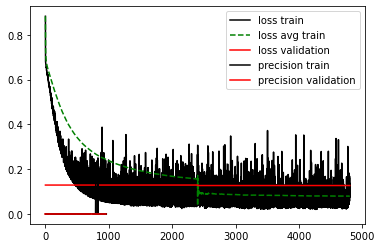

In [16]:


# visualize training loss history
plt.plot(range(len(histories['loss train'])), histories['loss train'], color='k', label='loss train')
plt.plot(range(len(histories['loss avg train'])), histories['loss avg train'], color='g', ls='dashed', label='loss avg train')
plt.plot(range(len(histories['loss validation'])), histories['loss validation'], color='r', label='loss validation')
plt.legend()



plt.plot(range(len(histories['precision train'])), histories['precision train'], color='k', label='precision train')
plt.plot(range(len(histories['precision validation'])), histories['precision validation'], color='r', label='precision validation')
plt.legend()



# pick model with best precision
best_model = best_models['best precision model']



In [17]:

def predict(model, dataloader): 

    # set model to evaluation mode
    model.eval()
    
    predictions = {}

    for i, (test_batch, pIds) in enumerate(dataloader):
        print('Predicting batch {} / {}.'.format(i+1, len(dataloader)))
        # Convert torch tensor to Variable
        test_batch = Variable(test_batch).cuda() if gpu_available else Variable(test_batch).float()
            
        # compute output
        output_batch = model(test_batch)
        sig = nn.Sigmoid().cuda()
        output_batch = sig(output_batch)
        output_batch = output_batch.data.cpu().numpy()
        for pId, output in zip(pIds, output_batch):
            predictions[pId] = output
        
    return predictions



In [18]:


# create predictions for the validation set to compare against ground truth
dataset_valid = PneumoniaDataset(root=image_path,  pIds=pIds_valid, predict=True, 
                                 boxes=None, rescale_factor=rescale_factor, transform=transform)
loader_valid = DataLoader(dataset=dataset_valid,
                          batch_size=batch_size,
                          shuffle=False) 

predictions_valid = predict(best_model, loader_valid)
print('Predicted {} validation images.'.format(len(predictions_valid)))



Predicting batch 1 / 267.
Predicting batch 2 / 267.
Predicting batch 3 / 267.
Predicting batch 4 / 267.
Predicting batch 5 / 267.
Predicting batch 6 / 267.
Predicting batch 7 / 267.
Predicting batch 8 / 267.
Predicting batch 9 / 267.
Predicting batch 10 / 267.
Predicting batch 11 / 267.
Predicting batch 12 / 267.
Predicting batch 13 / 267.
Predicting batch 14 / 267.
Predicting batch 15 / 267.
Predicting batch 16 / 267.
Predicting batch 17 / 267.
Predicting batch 18 / 267.
Predicting batch 19 / 267.
Predicting batch 20 / 267.
Predicting batch 21 / 267.
Predicting batch 22 / 267.
Predicting batch 23 / 267.
Predicting batch 24 / 267.
Predicting batch 25 / 267.
Predicting batch 26 / 267.
Predicting batch 27 / 267.
Predicting batch 28 / 267.
Predicting batch 29 / 267.
Predicting batch 30 / 267.
Predicting batch 31 / 267.
Predicting batch 32 / 267.
Predicting batch 33 / 267.
Predicting batch 34 / 267.
Predicting batch 35 / 267.
Predicting batch 36 / 267.
Predicting batch 37 / 267.
Predicting

Threshold: 0.01, average precision validation: 0.01131
Found new best average precision validation!
Threshold: 0.02, average precision validation: 0.02582
Found new best average precision validation!
Threshold: 0.03, average precision validation: 0.03745
Found new best average precision validation!
Threshold: 0.04, average precision validation: 0.04852
Found new best average precision validation!
Threshold: 0.05, average precision validation: 0.05926
Found new best average precision validation!
Threshold: 0.060000000000000005, average precision validation: 0.07015
Found new best average precision validation!
Threshold: 0.06999999999999999, average precision validation: 0.07656
Found new best average precision validation!
Threshold: 0.08, average precision validation: 0.08088
Found new best average precision validation!
Threshold: 0.09, average precision validation: 0.08412
Found new best average precision validation!
Threshold: 0.09999999999999999, average precision validation: 0.08649

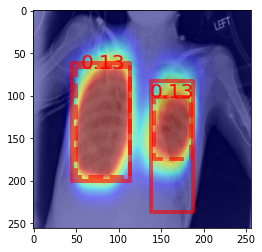

Prediction mask scale: 0.0017671231 - 0.10575186
Prediction string: 
Ground truth boxes: [[151, 138, 44, 43]]
Average precision image: 0.00000


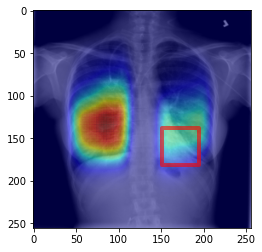

Prediction mask scale: 0.0017335963 - 0.048189066
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


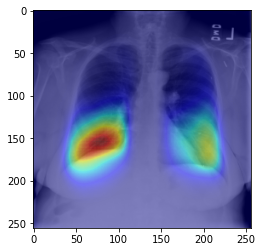

Prediction mask scale: 0.0017453067 - 0.14624512
Prediction string: 0.13273104 53 88 57 77 0.12368447 182 109 30 51
Ground truth boxes: []
Average precision image: 0.00000


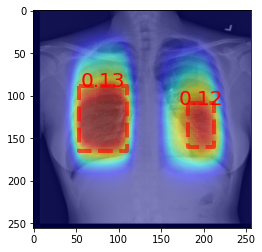

Prediction mask scale: 0.0017673511 - 0.038309913
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


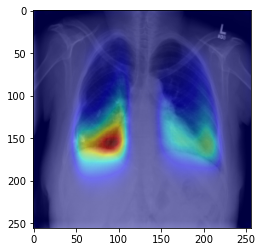

Prediction mask scale: 0.0017663428 - 0.036937192
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


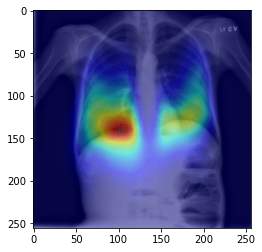

Prediction mask scale: 0.0017236884 - 0.07422619
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


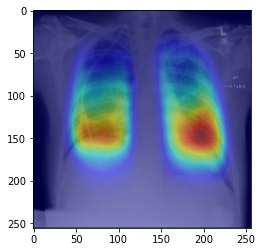

Prediction mask scale: 0.0017675118 - 0.044777416
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


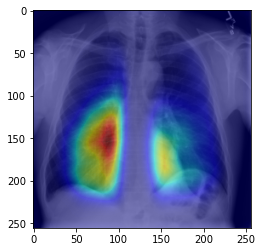

Prediction mask scale: 0.0017417918 - 0.06891594
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


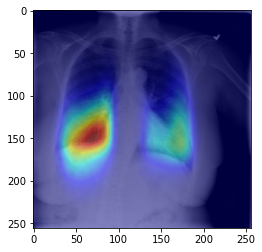

Prediction mask scale: 0.0017318379 - 0.1495015
Prediction string: 0.13334885 141 42 83 144 0.13671961 43 52 69 148
Ground truth boxes: []
Average precision image: 0.00000


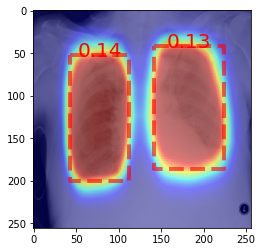

Prediction mask scale: 0.0017674682 - 0.14933194
Prediction string: 0.13515995 42 29 67 162 0.13227873 130 40 78 146
Ground truth boxes: []
Average precision image: 0.00000


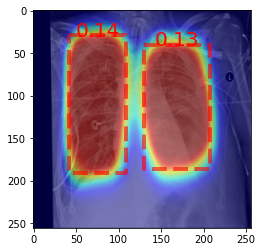

Prediction mask scale: 0.0017366622 - 0.1463834
Prediction string: 0.13089994 49 90 53 77
Ground truth boxes: []
Average precision image: 0.00000


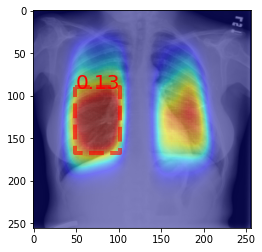

Prediction mask scale: 0.0017326929 - 0.14922038
Prediction string: 0.13503978 35 35 72 139 0.1283588 142 42 76 133
Ground truth boxes: []
Average precision image: 0.00000


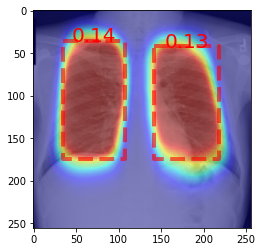

Prediction mask scale: 0.0017593496 - 0.14895019
Prediction string: 0.1367731 140 54 65 129 0.13276836 51 57 68 130
Ground truth boxes: []
Average precision image: 0.00000


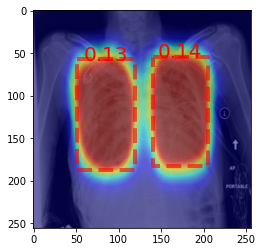

Prediction mask scale: 0.0017101273 - 0.14893109
Prediction string: 0.13079911 52 78 64 82
Ground truth boxes: []
Average precision image: 0.00000


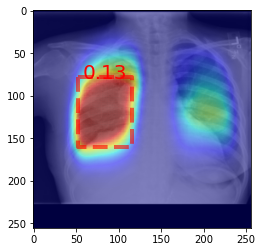

Prediction mask scale: 0.0017337888 - 0.04587983
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


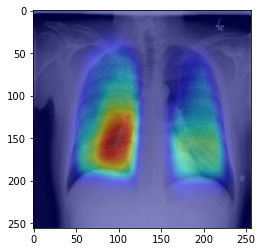

Prediction mask scale: 0.001721818 - 0.085344575
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


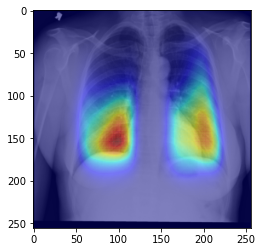

Prediction mask scale: 0.0017681387 - 0.082185455
Prediction string: 
Ground truth boxes: [[164, 180, 65, 52], [54, 166, 52, 56]]
Average precision image: 0.00000


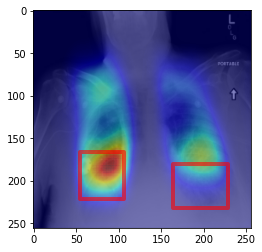

Prediction mask scale: 0.0017325083 - 0.13466759
Prediction string: 0.12355499 188 118 25 30
Ground truth boxes: []
Average precision image: 0.00000


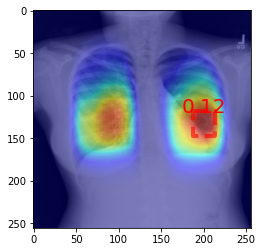

Prediction mask scale: 0.001767183 - 0.14604004
Prediction string: 0.12969565 48 66 49 95
Ground truth boxes: []
Average precision image: 0.00000


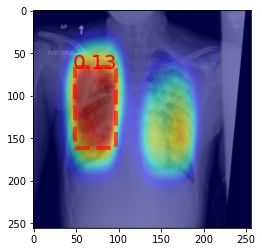

Prediction mask scale: 0.0017371839 - 0.14913042
Prediction string: 0.13259321 37 54 69 131 0.13269323 128 57 67 107
Ground truth boxes: [[119, 35, 94, 156], [27, 41, 85, 153]]
Average precision image: 0.41667


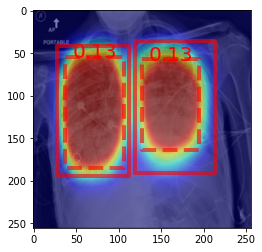

Prediction mask scale: 0.0017351509 - 0.1474693
Prediction string: 0.1273321 44 56 51 102 0.1267684 146 62 57 90
Ground truth boxes: []
Average precision image: 0.00000


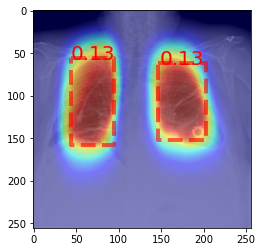

Prediction mask scale: 0.0017063478 - 0.13457888
Prediction string: 0.123749055 58 122 30 37
Ground truth boxes: [[164, 138, 50, 30], [70, 129, 42, 33]]
Average precision image: 0.00000


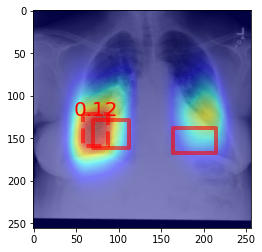

Prediction mask scale: 0.0017674228 - 0.033873685
Prediction string: 
Ground truth boxes: [[150, 62, 31, 39]]
Average precision image: 0.00000


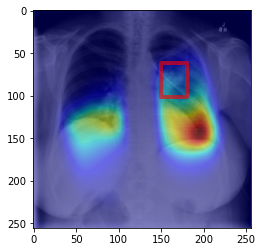

Prediction mask scale: 0.0017687776 - 0.14125367
Prediction string: 0.12704895 174 80 36 61
Ground truth boxes: []
Average precision image: 0.00000


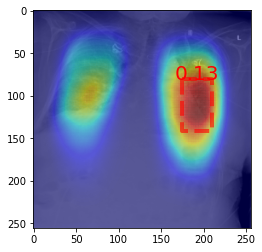

Prediction mask scale: 0.0017399 - 0.050843578
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


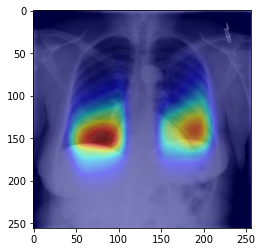

Prediction mask scale: 0.0017387201 - 0.1477845
Prediction string: 0.13133806 54 91 61 71 0.12831648 176 96 53 68
Ground truth boxes: []
Average precision image: 0.00000


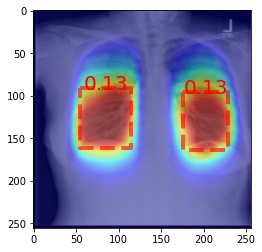

In [19]:

def rescale_box_coordinates(box, rescale_factor):
    x, y, w, h = box
    x = int(round(x/rescale_factor))
    y = int(round(y/rescale_factor))
    w = int(round(w/rescale_factor))
    h = int(round(h/rescale_factor))
    return [x, y, w, h]    



def draw_boxes(predicted_boxes, confidences, target_boxes, ax, angle=0):
    if len(predicted_boxes)>0:
        for box, c in zip(predicted_boxes, confidences):
            # extracting individual coordinates
            x, y, w, h = box 
            # create a rectangle patch
            patch = Rectangle((x,y), w, h, color='red', ls='dashed',
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            # get current axis and draw rectangle
            ax.add_patch(patch)
            # add confidence value in annotation text
            ax.text(x+w/2., y-5, '{:.2}'.format(c), color='red', size=20, va='center', ha='center')
    if len(target_boxes)>0:
        for box in target_boxes:
            # rescale and extract box coordinates
            x, y, w, h = box
            # create a rectangle patch
            patch = Rectangle((x,y), w, h, color='red',  
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            # get current axis and draw rectangle
            ax.add_patch(patch)
    
    return ax



# grid search to cross-validate the best threshold for the boxes
if debug:
    best_threshold = 0.2
else:
    best_threshold = None
    best_avg_precision_valid = 0.0
    thresholds = np.arange(0.01, 0.60, 0.01)
    avg_precision_valids = []
    for threshold in thresholds:
        precision_valid = []
        for i in range(len(dataset_valid)):
            img, pId = dataset_valid[i]
            target_boxes = [rescale_box_coordinates(box, rescale_factor) for box in pId_boxes_dict[pId]] if pId in pId_boxes_dict else []
            prediction = predictions_valid[pId]
            predicted_boxes, confidences = parse_boxes(prediction, threshold=threshold, connectivity=None)
            avg_precision_img = average_precision_image(predicted_boxes, confidences, target_boxes, shape=img[0].shape[0])
            precision_valid.append(avg_precision_img)
        avg_precision_valid = np.nanmean(precision_valid)
        avg_precision_valids.append(avg_precision_valid)
        print('Threshold: {}, average precision validation: {:03.5f}'.format(threshold, avg_precision_valid))
        if avg_precision_valid>best_avg_precision_valid:
            print('Found new best average precision validation!')
            best_avg_precision_valid = avg_precision_valid
            best_threshold = threshold
    plt.plot(thresholds, avg_precision_valids)



# check the results on the validation set
for i in range(len(dataset_valid)):
    img, pId = dataset_valid[i]
    target_boxes = [rescale_box_coordinates(box, rescale_factor) for box in pId_boxes_dict[pId]] if pId in pId_boxes_dict else []
    prediction = predictions_valid[pId]
    predicted_boxes, confidences = parse_boxes(prediction, threshold=best_threshold, connectivity=None)
    avg_precision_img = average_precision_image(predicted_boxes, confidences, target_boxes, shape=img[0].shape[0])
    if i%100==0: # print every 100
        plt.imshow(img[0], cmap=mpl.cm.gist_gray) # [0] is the channel index (here there's just one channel)
        plt.imshow(prediction[0], cmap=mpl.cm.jet, alpha=0.5)
        draw_boxes(predicted_boxes, confidences, target_boxes, plt.gca())
        print('Prediction mask scale:', prediction[0].min(), '-', prediction[0].max())
        print('Prediction string:', prediction_string(predicted_boxes, confidences))
        print('Ground truth boxes:', target_boxes)
        print('Average precision image: {:05.5f}'.format(avg_precision_img))
        plt.show()

